Vi lager et program som lar brukeren velge et sted i Norge og se den historiske værdataene til dette stedet. Programmet henter informasjon fra den nærmeste værstasjonen til det valgte stedet og visualiserer dataene i grafer. Programmet viser også en beregning for hvordan framtidig vær kommer til å se ut. All data er hentet fra MET som er en offentlig kilde sponset fra den norske stat

In [111]:
import requests
import pandas as pd
import os
import sys
from datetime import datetime, timedelta
from opencage.geocoder import OpenCageGeocode
from geopy.distance import geodesic
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from API_Key_Manager_class import APIKeyManager

api_key_manager = APIKeyManager()

# Hent Frost API-nøkkelen direkte fra klassen
client_id = api_key_manager.get_api_key("Frost")

# Hent Opencage API-nøkkelen direkte fra klassen
api_key = api_key_manager.get_api_key("Opencage")

# Sett opp OpenCageGeocode med API-nøkkelen din
geolocator = OpenCageGeocode(api_key)

# Henter inn lokasjon fra brukeren
location_input = input("Enter the location (e.g., Bergen, Oslo, Trondheim, Stavanger, Tromsø): ")

# Geokoder lokasjonen for å få koordinatene
location = geolocator.geocode(location_input)

# Sjekker om geokodingen var vellykket
if location:
    # Henter ut koordinatene
    location_coords = (location[0]['geometry']['lat'], location[0]['geometry']['lng'])
else:
    raise ValueError("Could not find coordinates for the location. Please check the input.")

# Definerer endepunkt og parametere for stasjoner
stations_endpoint = 'https://frost.met.no/sources/v0.jsonld'
stations_parameters = {
    'types': 'SensorSystem'
}

# Henter ut HTTP-responsen og lagrer den som JSON
r = requests.get(stations_endpoint, stations_parameters, auth=(client_id, ''))
stations_json = r.json()

# Henter ut stasjonsinformasjonen
stations = stations_json['data']

# Lager et dictionary med stasjons-ID som nøkkel og koordinater som verdi
weather_stations_coords = {station['id']: (station['geometry']['coordinates'][1], station['geometry']['coordinates'][0]) for station in stations if 'geometry' in station}

# Regner ut avstanden til værstasjonene fra lokasjonen
distances = {station: geodesic(location_coords, coords).km for station, coords in weather_stations_coords.items()}

# Sorterer værstasjonene etter avstand til lokasjonen
sorted_stations = sorted(distances, key=distances.get)

# Henter ut dagens dato og datoen 90 dager tilbake
now = datetime.now()
days = 365*7
offset = now - timedelta(days)
current_date = now.strftime("%Y-%m-%d")
historic_date = offset.strftime("%Y-%m-%d")

# Definerer endepunkt og parametere for observasjoner
observations_endpoint = 'https://frost.met.no/observations/v0.jsonld'

def fetch_data_by_element(stations, elements, max_attempts = 15):
    """
    Fetch data for each element (e.g., temperature, precipitation, wind speed) from the nearest weather stations.
    Tries up to max_attempts stations for each element and returns the data for the first successful attempt.
    """
    all_data = {}
    
    for element in elements:
        print(f"Henter data for element: {element}")
        for attempt in range(min(max_attempts, len(stations))):
            parameters = {
                'sources': stations[attempt],
                'elements': element,
                'referencetime': f'{historic_date}/{current_date}',
            }
            r = requests.get(observations_endpoint, parameters, auth=(client_id, ''))
            json = r.json()

            if r.status_code == 200 and 'data' in json:
                data = json['data']
                if data:
                    print(f"Data retrieved for {element} from station {stations[attempt]}!")
                    all_data[element] = data
                    break
            else:
                print(f"Error retrieving {element} data from station {stations[attempt]}. Trying next station...")
        
        # Hvis ingen data blir funnet for elementet, logges en melding
        if element not in all_data:
            print(f"No data found for {element} from any of the attempted stations.")
    
    return all_data

# Elementene vi ønsker å hente data for
elements = [
    'mean(air_temperature P1D)', 
    'sum(precipitation_amount P1D)', 
    'mean(wind_speed P1D)',
    'mean(relative_humidity P1D)'
]

# Henter data for lokasjonen
data = fetch_data_by_element(sorted_stations, elements)

# Samler de viktige dataene i en DataFrame
df_list = []

for element, data_element in data.items():
    for item in data_element:
        row = pd.DataFrame(item['observations'])
        row['referenceTime'] = item['referenceTime']
        row['sourceId'] = item['sourceId']
        row['elementId'] = element
        df_list.append(row)

# Effektivt å koble sammen alle DataFrames samtidig
df = pd.concat(df_list, ignore_index=True)

df['referenceTime'] = pd.to_datetime(df['referenceTime'])

# Delete specific columns
columns_to_delete = ["level","timeResolution","timeSeriesId","performanceCategory","exposureCategory","qualityCode"]
try:
    df.drop(columns=columns_to_delete, inplace=True)
except Exception as e:
    print("Error:", e)

# Lagrer dataene i CSV-filer (overskriver eksisterende fil)

# Filtrerer og lagrer data for temperatur
temperature_data = df[df['elementId'] == 'mean(air_temperature P1D)']
temperature_data.to_csv("../data/temperature_data.csv", index=False)

# Filtrerer og lagrer data for nedbør
precipitation_data = df[df['elementId'] == 'sum(precipitation_amount P1D)']
precipitation_data.to_csv("../data/precipitation_data.csv", index=False)

# Filtrerer og lagrer data for vindhastighet
wind_speed_data = df[df['elementId'] == 'mean(wind_speed P1D)']
wind_speed_data.to_csv("../data/wind_speed_data.csv", index=False)

# Filtrerer og lagrer data for relativ luftfuktighet
humidity_data = df[df['elementId'] == 'mean(relative_humidity P1D)']
humidity_data.to_csv("../data/humidity_data.csv", index=False)


Henter data for element: mean(air_temperature P1D)
Data retrieved for mean(air_temperature P1D) from station SN90450!
Henter data for element: sum(precipitation_amount P1D)
Data retrieved for sum(precipitation_amount P1D) from station SN90450!
Henter data for element: mean(wind_speed P1D)
Data retrieved for mean(wind_speed P1D) from station SN90450!
Henter data for element: mean(relative_humidity P1D)
Data retrieved for mean(relative_humidity P1D) from station SN90450!


In [112]:
import pandas as pd

# Les inn data fra CSV
precipitation_data = pd.read_csv("../data/precipitation_data.csv")
temperature_data = pd.read_csv("../data/temperature_data.csv")
wind_speed_data = pd.read_csv("../data/wind_speed_data.csv")
humidity_data = pd.read_csv("../data/humidity_data.csv")

# Konverter referenceTime til datetime
precipitation_data['referenceTime'] = pd.to_datetime(precipitation_data['referenceTime'], errors='coerce')
temperature_data['referenceTime'] = pd.to_datetime(temperature_data['referenceTime'], errors='coerce')
wind_speed_data['referenceTime'] = pd.to_datetime(wind_speed_data['referenceTime'], errors='coerce')
humidity_data['referenceTime'] = pd.to_datetime(humidity_data['referenceTime'], errors='coerce')

# Ekstraher antall timer fra timeOffset (for eksempel "PT6" -> 6)
precipitation_data['timeOffsetHours'] = precipitation_data['timeOffset'].str.extract(r'PT(\d+)').astype(float)
temperature_data['timeOffsetHours'] = temperature_data['timeOffset'].str.extract(r'PT(\d+)').astype(float)
wind_speed_data['timeOffsetHours'] = wind_speed_data['timeOffset'].str.extract(r'PT(\d+)').astype(float)
humidity_data['timeOffsetHours'] = humidity_data['timeOffset'].str.extract(r'PT(\d+)').astype(float)

# Legg til timeOffset i referenceTime
precipitation_data['referenceTime'] = precipitation_data['referenceTime'] + pd.to_timedelta(precipitation_data['timeOffsetHours'], unit='h')
temperature_data['referenceTime'] = temperature_data['referenceTime'] + pd.to_timedelta(temperature_data['timeOffsetHours'], unit='h')
wind_speed_data['referenceTime'] = wind_speed_data['referenceTime'] + pd.to_timedelta(wind_speed_data['timeOffsetHours'], unit='h')
humidity_data['referenceTime'] = humidity_data['referenceTime'] + pd.to_timedelta(humidity_data['timeOffsetHours'], unit='h')

# Slett timeOffsetHours-kolonnen
precipitation_data.drop(columns=['timeOffsetHours'], inplace=True)
temperature_data.drop(columns=['timeOffsetHours'], inplace=True)
wind_speed_data.drop(columns=['timeOffsetHours'], inplace=True)
humidity_data.drop(columns=['timeOffsetHours'], inplace=True)

# Lagre tilbake til CSV
precipitation_data.to_csv("../data/precipitation_data.csv", index=False)
temperature_data.to_csv("../data/temperature_data.csv", index=False)
wind_speed_data.to_csv("../data/wind_speed_data.csv", index=False)
humidity_data.to_csv("../data/humidity_data.csv", index=False)

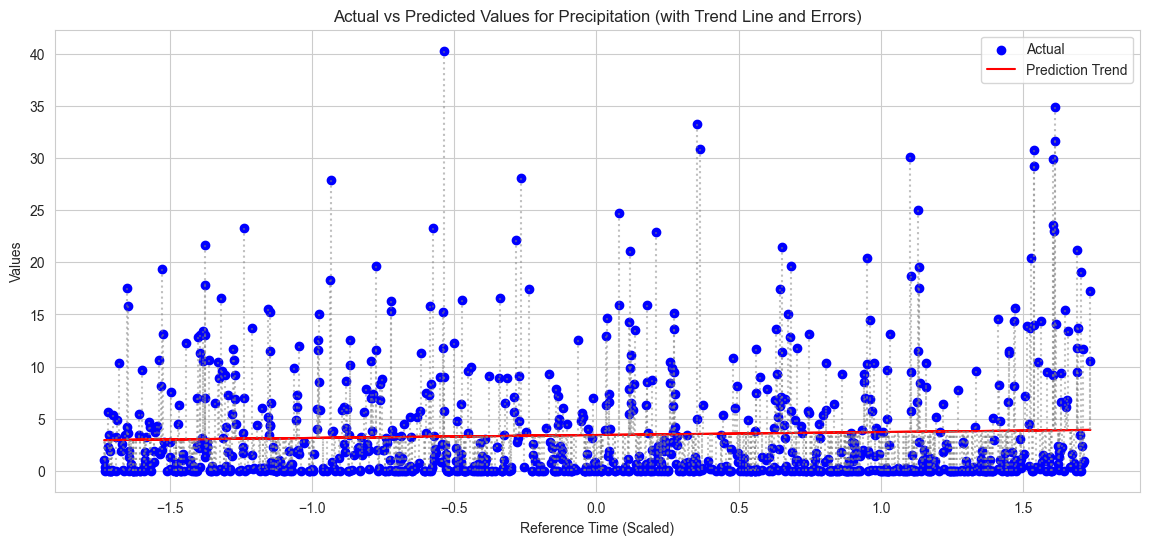

Mean Abspolute Error: 3.985867172610824
R-squared: 0.0018384948285073976


In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Les inn data
precipitation_data = pd.read_csv("../data/precipitation_data.csv")

# Konverter referenceTime til datetime
precipitation_data['referenceTime'] = pd.to_datetime(precipitation_data['referenceTime'], errors='coerce')

# Fjern rader med NaT i referenceTime
precipitation_data = precipitation_data.dropna(subset=['referenceTime'])

X_regn = precipitation_data['referenceTime']
Y_regn = precipitation_data['value']


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_regn, Y_regn, test_size=0.2, random_state=0)

# Reshape the data to 2D arrays
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

# Feature Scaling
scaler = StandardScaler()

# Fits the StandardScaler to the data and then transforms the data.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled,X_train_scaled

# Convert scaled arrays back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['referenceTime'])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['referenceTime'])

# Train a linear regression model and make predictions on the test set
regr = LinearRegression()
regr.fit(X_train_scaled_df, y_train)

# Predict on the test set
y_pred = regr.predict(X_test_scaled_df)

# Visualize predictions vs actual values
plt.figure(figsize=(14, 6))
plt.scatter(X_test_scaled_df['referenceTime'], y_test, color='blue', label='Actual')
plt.plot(X_test_scaled_df['referenceTime'], y_pred, color='red', label='Prediction Trend')
for i in range(len(X_test_scaled_df)):
    plt.plot([X_test_scaled_df['referenceTime'].iloc[i], X_test_scaled_df['referenceTime'].iloc[i]],
             [y_test.iloc[i], y_pred[i]], color='gray', linestyle='dotted', alpha=0.5)
plt.title('Actual vs Predicted Values for Precipitation (with Trend Line and Errors)')
plt.xlabel('Reference Time (Scaled)')
plt.ylabel('Values')
plt.legend()
plt.show()

print("Mean Abspolute Error:", mean_absolute_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))



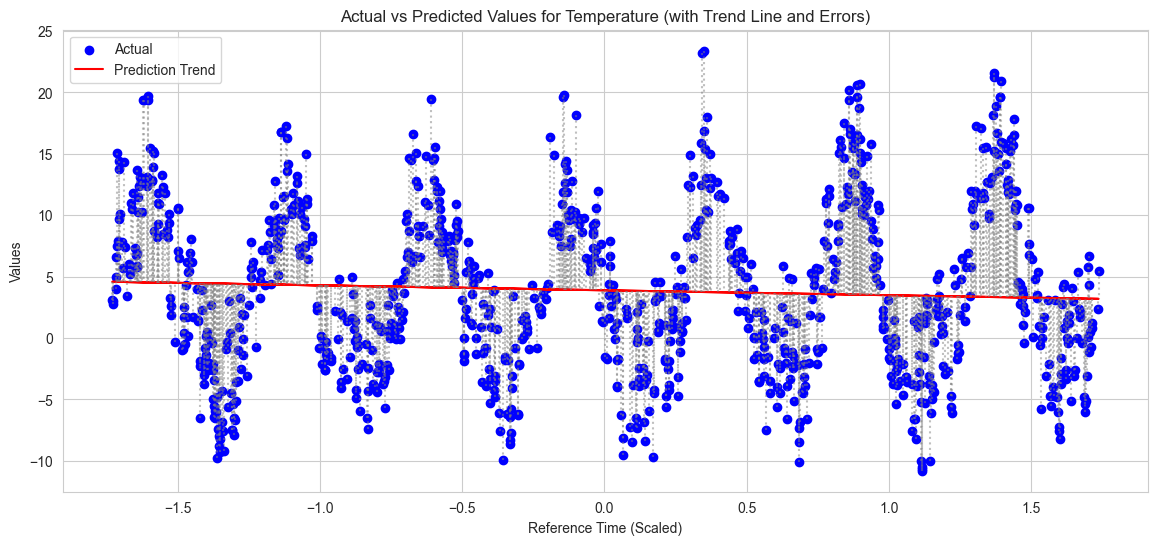

Mean Abspolute Error: 5.647878513457141
R-squared: -0.0008429963333804746


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Les inn data
temperature_data = pd.read_csv("../data/temperature_data.csv")

# Konverter referenceTime til datetime
temperature_data['referenceTime'] = pd.to_datetime(temperature_data['referenceTime'], errors='coerce')

# Fjern rader med NaT i referenceTime
temperature_data = temperature_data.dropna(subset=['referenceTime'])

X_regn = temperature_data['referenceTime']
Y_regn = temperature_data['value']


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_regn, Y_regn, test_size=0.2, random_state=0)

# Reshape the data to 2D arrays
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

# Feature Scaling
scaler = StandardScaler()

# Fits the StandardScaler to the data and then transforms the data.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled,X_train_scaled

# Convert scaled arrays back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['referenceTime'])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['referenceTime'])

# Train a linear regression model and make predictions on the test set
regr = LinearRegression()
regr.fit(X_train_scaled_df, y_train)

# Predict on the test set
y_pred = regr.predict(X_test_scaled_df)

# Visualize predictions vs actual values
plt.figure(figsize=(14, 6))
plt.scatter(X_test_scaled_df['referenceTime'], y_test, color='blue', label='Actual')
plt.plot(X_test_scaled_df['referenceTime'], y_pred, color='red', label='Prediction Trend')
for i in range(len(X_test_scaled_df)):
    plt.plot([X_test_scaled_df['referenceTime'].iloc[i], X_test_scaled_df['referenceTime'].iloc[i]],
             [y_test.iloc[i], y_pred[i]], color='gray', linestyle='dotted', alpha=0.5)
plt.title('Actual vs Predicted Values for Temperature (with Trend Line and Errors)')
plt.xlabel('Reference Time (Scaled)')
plt.ylabel('Values')
plt.legend()
plt.show()

print("Mean Abspolute Error:", mean_absolute_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))



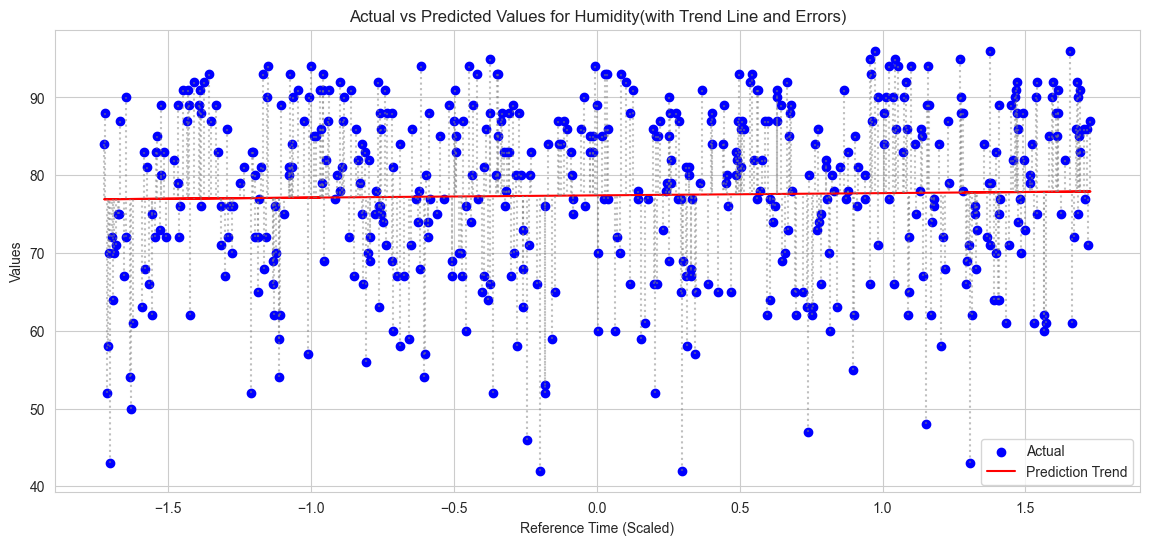

Mean Abspolute Error: 9.194248490779874
R-squared: 0.0016297745335921432


In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


# Les inn data
humidity_data = pd.read_csv("../data/humidity_data.csv")

# Konverter referenceTime til datetime
humidity_data['referenceTime'] = pd.to_datetime(humidity_data['referenceTime'], errors='coerce')

# Fjern rader med NaT i referenceTime
humidity_data = humidity_data.dropna(subset=['referenceTime'])

X_regn = humidity_data['referenceTime']
Y_regn = humidity_data['value']


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_regn, Y_regn, test_size=0.2, random_state=0)

# Reshape the data to 2D arrays
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

# Feature Scaling
scaler = StandardScaler()

# Fits the StandardScaler to the data and then transforms the data.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled,X_train_scaled

# Convert scaled arrays back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['referenceTime'])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['referenceTime'])

# Train a linear regression model and make predictions on the test set
regr = LinearRegression()
regr.fit(X_train_scaled_df, y_train)

# Predict on the test set
y_pred = regr.predict(X_test_scaled_df)

# Visualize predictions vs actual values
plt.figure(figsize=(14, 6))
plt.scatter(X_test_scaled_df['referenceTime'], y_test, color='blue', label='Actual')
plt.plot(X_test_scaled_df['referenceTime'], y_pred, color='red', label='Prediction Trend')
for i in range(len(X_test_scaled_df)):
    plt.plot([X_test_scaled_df['referenceTime'].iloc[i], X_test_scaled_df['referenceTime'].iloc[i]],
             [y_test.iloc[i], y_pred[i]], color='gray', linestyle='dotted', alpha=0.5)
plt.title('Actual vs Predicted Values for Humidity(with Trend Line and Errors)')
plt.xlabel('Reference Time (Scaled)')
plt.ylabel('Values')
plt.legend()
plt.show()

print("Mean Abspolute Error:", mean_absolute_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))



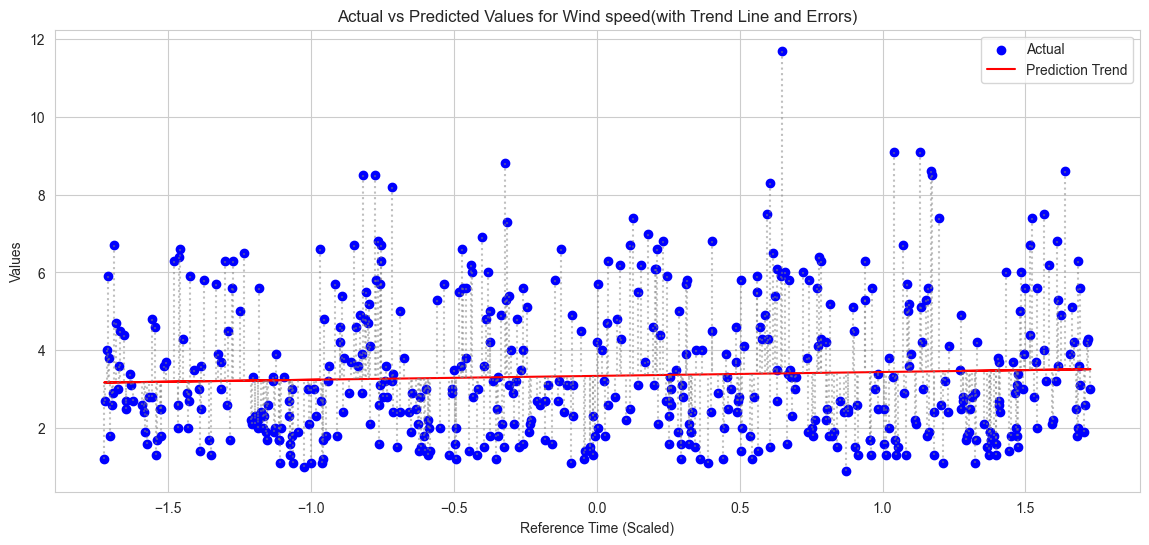

Mean Abspolute Error: 1.4592464969746368
R-squared: -0.0017573066948126659


In [116]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Les inn data
temperature_data = pd.read_csv("../data/wind_speed_data.csv")

# Konverter referenceTime til datetime
wind_speed_data['referenceTime'] = pd.to_datetime(wind_speed_data['referenceTime'], errors='coerce')

# Fjern rader med NaT i referenceTime
wind_speed_data = wind_speed_data.dropna(subset=['referenceTime'])

X_regn = wind_speed_data['referenceTime']
Y_regn = wind_speed_data['value']


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_regn, Y_regn, test_size=0.2, random_state=0)

# Reshape the data to 2D arrays
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

# Feature Scaling
scaler = StandardScaler()

# Fits the StandardScaler to the data and then transforms the data.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled,X_train_scaled

# Convert scaled arrays back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['referenceTime'])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['referenceTime'])

# Train a linear regression model and make predictions on the test set
regr = LinearRegression()
regr.fit(X_train_scaled_df, y_train)

# Predict on the test set
y_pred = regr.predict(X_test_scaled_df)

# Visualize predictions vs actual values
plt.figure(figsize=(14, 6))
plt.scatter(X_test_scaled_df['referenceTime'], y_test, color='blue', label='Actual')
plt.plot(X_test_scaled_df['referenceTime'], y_pred, color='red', label='Prediction Trend')
for i in range(len(X_test_scaled_df)):
    plt.plot([X_test_scaled_df['referenceTime'].iloc[i], X_test_scaled_df['referenceTime'].iloc[i]],
             [y_test.iloc[i], y_pred[i]], color='gray', linestyle='dotted', alpha=0.5)
plt.title('Actual vs Predicted Values for Wind speed(with Trend Line and Errors)')
plt.xlabel('Reference Time (Scaled)')
plt.ylabel('Values')
plt.legend()
plt.show()

print("Mean Abspolute Error:", mean_absolute_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))



In [117]:
# Importerer nødvendige biblioteker
import pandas as pd
import plotly.graph_objects as go

# Leser data fra de separate CSV-filene
temperature_data = pd.read_csv("../data/temperature_data.csv")
precipitation_data = pd.read_csv("../data/precipitation_data.csv")
wind_speed_data = pd.read_csv("../data/wind_speed_data.csv")
humidity_data = pd.read_csv("../data/humidity_data.csv")

# Konverterer referansetiden til datetime for alle datasettene
temperature_data['referenceTime'] = pd.to_datetime(temperature_data['referenceTime'])
precipitation_data['referenceTime'] = pd.to_datetime(precipitation_data['referenceTime'])
wind_speed_data['referenceTime'] = pd.to_datetime(wind_speed_data['referenceTime'])
humidity_data['referenceTime'] = pd.to_datetime(humidity_data['referenceTime'])

# Plotter temperaturdata
fig_temp = go.Figure()
fig_temp.add_trace(go.Scatter(
    x=temperature_data['referenceTime'],
    y=temperature_data['value'],
    mode='lines',
    name='Temperatur',
    line=dict(color='#1f77b4')
))
mean_temp = temperature_data['value'].mean()
median_temp = temperature_data['value'].median()
fig_temp.add_trace(go.Scatter(
    x=temperature_data['referenceTime'],
    y=[mean_temp] * len(temperature_data['referenceTime']),
    mode='lines',
    line=dict(dash='dash', color='rgba(31, 119, 180)'),
    name='Gjennomsnittstemperatur'
))
fig_temp.update_layout(
    title=f"Temperatur over tid<br>Gjennomsnitt: {mean_temp:.2f} °C, Median: {median_temp:.2f} °C",
    xaxis_title="Dato",
    yaxis_title="Temperatur (°C)"
)
fig_temp.show()

# Plotter nedbørsdata
fig_precip = go.Figure()
fig_precip.add_trace(go.Bar(
    x=precipitation_data['referenceTime'],
    y=precipitation_data['value'],
    name='Nedbør',
    marker=dict(color='#1f77b4')
))
mean_precip = precipitation_data['value'].mean()
median_precip = precipitation_data['value'].median()
fig_precip.add_trace(go.Scatter(
    x=precipitation_data['referenceTime'],
    y=[mean_precip] * len(precipitation_data['referenceTime']),
    mode='lines',
    line=dict(dash='dash', color='rgba(31, 119, 180)'),
    name='Gjennomsnittsnedbør'
))
fig_precip.update_layout(
    title=f"Nedbør over tid<br>Gjennomsnitt: {mean_precip:.2f} mm, Median: {median_precip:.2f} mm",
    xaxis_title="Dato",
    yaxis_title="Nedbør (mm)"
)
fig_precip.show()

# Plotter vindhastighetsdata
fig_wind = go.Figure()
fig_wind.add_trace(go.Scatter(
    x=wind_speed_data['referenceTime'],
    y=wind_speed_data['value'],
    mode='lines',
    name='Vindhastighet',
    line=dict(color='#1f77b4')
))
mean_wind = wind_speed_data['value'].mean()
median_wind = wind_speed_data['value'].median()
fig_wind.add_trace(go.Scatter(
    x=wind_speed_data['referenceTime'],
    y=[mean_wind] * len(wind_speed_data['referenceTime']),
    mode='lines',
    line=dict(dash='dash', color='rgba(31, 119, 180)'),
    name='Gjennomsnittsvindhastighet'
))
fig_wind.update_layout(
    title=f"Vindhastighet over tid<br>Gjennomsnitt: {mean_wind:.2f} m/s, Median: {median_wind:.2f} m/s",
    xaxis_title="Dato",
    yaxis_title="Vindhastighet (m/s)"
)
fig_wind.show()

# Plotter luftfuktighetsdata
fig_humidity = go.Figure()
fig_humidity.add_trace(go.Scatter(
    x=humidity_data['referenceTime'],
    y=humidity_data['value'],
    mode='lines',
    name='Luftfuktighet',
    line=dict(color='#1f77b4')
))
mean_humidity = humidity_data['value'].mean()
median_humidity = humidity_data['value'].median()
fig_humidity.add_trace(go.Scatter(
    x=humidity_data['referenceTime'],
    y=[mean_humidity] * len(humidity_data['referenceTime']),
    mode='lines',
    line=dict(dash='dash', color='rgba(31, 119, 180)'),
    name='Gjennomsnittlig luftfuktighet'
))
fig_humidity.update_layout(
    title=f"Luftfuktighet over tid<br>Gjennomsnitt: {mean_humidity:.2f} %, Median: {median_humidity:.2f} %",
    xaxis_title="Dato",
    yaxis_title="Relativ luftfuktighet (%)"
)
fig_humidity.show()